In [4]:
!pip install split-folders


In [5]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 30.2 MB/s eta 0:00:00


In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import mediapipe as mp
import cv2
import os
import splitfolders
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# Step 1: Preprocess Data with MediaPipe
def preprocess_with_mediapipe(input_folder, output_folder):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for label in os.listdir(input_folder):
        label_folder = os.path.join(input_folder, label)
        output_label_folder = os.path.join(output_folder, label)

        if not os.path.exists(output_label_folder):
            os.makedirs(output_label_folder)

        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            # Detect faces
            results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.detections:
                for detection in results.detections:
                    bboxC = detection.location_data.relative_bounding_box
                    ih, iw, _ = image.shape
                    x, y, w, h = (int(bboxC.xmin * iw), int(bboxC.ymin * ih),
                                  int(bboxC.width * iw), int(bboxC.height * ih))
                    if x >= 0 and y >= 0 and x + w <= iw and y + h <= ih:
                        cropped_face = image[y:y + h, x:x + w]
                        resized_face = cv2.resize(cropped_face, (160, 160))
                        # Save processed face
                        output_path = os.path.join(output_label_folder, image_file)
                        cv2.imwrite(output_path, resized_face)
                    else:
                        print(f"Invalid bounding box for image: {image_path}")
            else:
                print(f"No face detected in image: {image_path}")

    print("Preprocessing completed with MediaPipe.")


In [38]:
# Preprocess images
preprocess_with_mediapipe('/content/drive/My Drive/Database/Foto_Resize_Rotate_160x160', '/content/drive/My Drive/Database/Preprocessed_Dataset_160x160')

No face detected in image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Keiko/Keiko_67.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Keiko/Keiko_27.jpg
No face detected in image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Keiko/Keiko_75.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Hafidz/Hafidz_3.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Hafidz/Hafidz_22.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Hafidz/Hafidz_23.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Hafidz/Hafidz_14.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Hafidz/Hafidz_31.jpg
Invalid bounding box for image: /content/drive/My Drive/Database/Foto_Resize_Rotate_160x160/Hafidz/Hafidz_15.jpg


In [40]:
# Step 2: Split Dataset into Train, Validation, and Test
splitfolders.ratio(
    '/content/drive/My Drive/Database/Preprocessed_Dataset_160x160',  # Input folder after preprocessing
    output="/content/drive/My Drive/Database",  # Output folder
    seed=42,
    ratio=(0.7, 0.15, 0.15)  # Train:Validation:Test ratio
)
print("Dataset splitting completed.")


Copying files: 0 files [00:00, ? files/s]
Copying files: 4 files [00:00, 34.56 files/s]
Copying files: 9 files [00:00, 41.20 files/s]
Copying files: 15 files [00:00, 47.35 files/s]
Copying files: 23 files [00:00, 53.60 files/s]
Copying files: 29 files [00:00, 55.24 files/s]
Copying files: 35 files [00:00, 56.45 files/s]
Copying files: 43 files [00:00, 63.23 files/s]
Copying files: 50 files [00:00, 59.54 files/s]
Copying files: 57 files [00:01, 62.34 files/s]
Copying files: 64 files [00:01, 60.62 files/s]
Copying files: 71 files [00:01, 56.11 files/s]
Copying files: 78 files [00:01, 59.70 files/s]
Copying files: 85 files [00:01, 56.95 files/s]
Copying files: 92 files [00:01, 58.83 files/s]
Copying files: 98 files [00:01, 58.49 files/s]
Copying files: 105 files [00:01, 60.54 files/s]
Copying files: 112 files [00:01, 59.10 files/s]
Copying files: 119 files [00:02, 57.83 files/s]
Copying files: 126 files [00:02, 58.89 files/s]
Copying files: 132 files [00:02, 55.11 files/s]
Copying files:

Dataset splitting completed.


In [41]:
# Step 3: Load Dataset with ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

train_dataset = datagen.flow_from_directory(
    '/content/drive/My Drive/Database/train',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)

validation_dataset = datagen.flow_from_directory(
    '/content/drive/My Drive/Database/val',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    '/content/drive/My Drive/Database/test',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle for evaluation
)

Found 927 images belonging to 15 classes.
Found 193 images belonging to 15 classes.
Found 211 images belonging to 15 classes.


In [42]:
# Step 4: Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(160, 160, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_dataset.class_indices), activation='softmax')  # Output = number of classes
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Step 5: Train Model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.1129 - loss: 2.6932 - val_accuracy: 0.2953 - val_loss: 2.2110
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4051 - loss: 1.9020 - val_accuracy: 0.5648 - val_loss: 1.3376
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.6811 - loss: 1.0610 - val_accuracy: 0.7098 - val_loss: 1.0030
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8090 - loss: 0.6473 - val_accuracy: 0.7047 - val_loss: 0.8667
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9182 - loss: 0.2926 - val_accuracy: 0.6943 - val_loss: 0.9882
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9262 - loss: 0.2250 - val_accuracy: 0.7150 - val_loss: 1.0945
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9430 - loss: 0.2187 - val_accuracy: 0.7409 - val_loss: 0.8402
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9813 - loss: 0.0786 - val_accuracy: 0.7668 - val_loss: 0.7499
Epo

In [44]:
# Step 6: Save the Model
model.save('face_recognition_model.h5')
print("Model training completed and saved.")

Model training completed and saved.


In [45]:
# Step 7: Evaluate Model on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 834ms/step - accuracy: 0.8290 - loss: 1.2048
Test Accuracy: 0.83


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 724ms/step


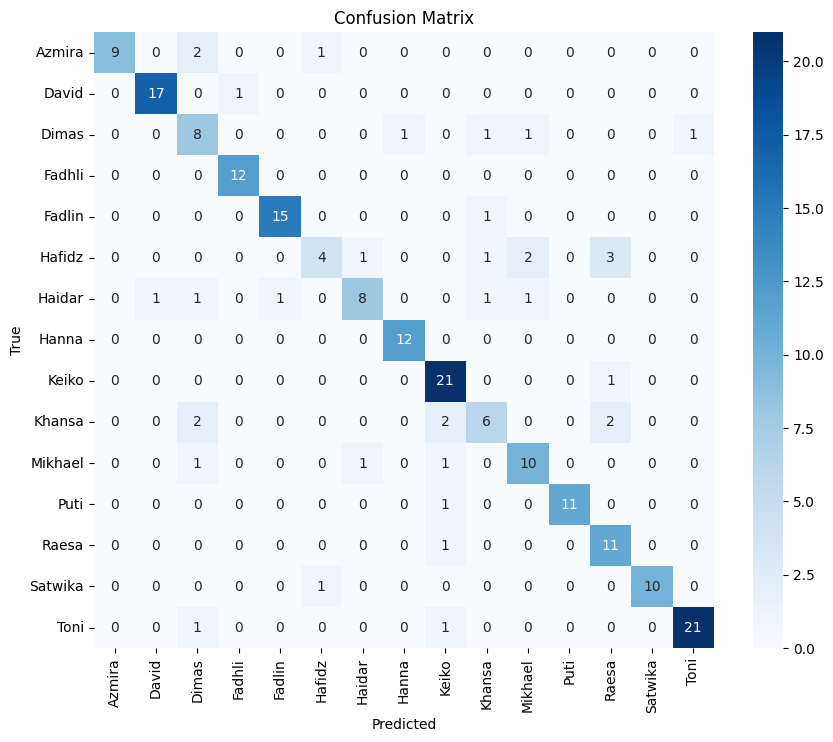

Classification Report:
              precision    recall  f1-score   support

      Azmira       1.00      0.75      0.86        12
       David       0.94      0.94      0.94        18
       Dimas       0.53      0.67      0.59        12
      Fadhli       0.92      1.00      0.96        12
      Fadlin       0.94      0.94      0.94        16
      Hafidz       0.67      0.36      0.47        11
      Haidar       0.80      0.62      0.70        13
       Hanna       0.92      1.00      0.96        12
       Keiko       0.78      0.95      0.86        22
      Khansa       0.60      0.50      0.55        12
     Mikhael       0.71      0.77      0.74        13
        Puti       1.00      0.92      0.96        12
       Raesa       0.65      0.92      0.76        12
     Satwika       1.00      0.91      0.95        11
        Toni       0.95      0.91      0.93        23

    accuracy                           0.83       211
   macro avg       0.83      0.81      0.81       211
wei

In [46]:
# Step 8: Generate Confusion Matrix
Y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(Y_pred, axis=1)  # Predicted class
y_true = test_dataset.classes  # True labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.class_indices.keys(), yticklabels=test_dataset.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=test_dataset.class_indices.keys())
print("Classification Report:")
print(report)